In [1]:
import numpy as np 
import pandas as pd 
import glob
import cv2
import os
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
import albumentations as albu
from skimage.color import gray2rgb
from sklearn.utils import resample
import functools
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_csv_path = '/kaggle/input/df-filtered-after-eda/final_df_Pulmonary_Embolism_CT_scans_data.csv'
jpeg_dir = '/kaggle/input/rsna-str-pe-detection-jpeg-256/train-jpegs'

In [3]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,...,table_height,x_ray_tube_current,exposure,patient_position,detector_tilt,bits_allocated,rescale_intercept,rescale_slope,photometric_interpretation,convolution_kernel
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,...,139.0,964,124,HFS,0.0,16,-1024.0,1.0,MONOCHROME2,B30f


In [4]:
def filter_slices(group):
    n = len(group)
    start = int(0.1 * n)
    end = int(0.9 * n)
    return group.iloc[start:end]

train_df_80 = train_df.groupby('SeriesInstanceUID').apply(filter_slices).reset_index(drop=True)
len(train_df_80)

1274272

In [6]:
df_positive = train_df_80[train_df_80['pe_present_on_image'] == 1]
df_negative = train_df_80[train_df_80['pe_present_on_image'] == 0]

# Subsampling
df_positive_downsampled = resample(df_positive,
                                   replace=False,
                                   n_samples=72500,  
                                   random_state=42)

df_negative_downsampled = resample(df_negative,
                                   replace=False,
                                   n_samples=72500, 
                                   random_state=42)
df_balanced = pd.concat([df_positive_downsampled, df_negative_downsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['pe_present_on_image'].value_counts())

pe_present_on_image
1    72500
0    72500
Name: count, dtype: int64


In [7]:
def get_training_augmentation(y=256, x=256):
    train_transform = [
        #albu.RandomBrightnessContrast(p=0.3),
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=20, p=0.5),
        albu.RandomResizedCrop(height=y, width=x, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albu.GridDistortion(p=0.3),
        albu.Downscale(p=0.5, scale_min=0.35, scale_max=0.75),
        albu.ToGray(p=1.0),  # Aplicar escala de grises
        albu.Resize(y, x)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(y=256, x=256):
    test_transform = [
        albu.CenterCrop(height=int(y * 0.8), width=int(x * 0.8), p=1.0),
        albu.Resize(y, x)
    ]
    return albu.Compose(test_transform)


def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):
    if input_space == "BGR":
        x = x[..., ::-1].copy()
        
    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0         
    if mean is not None:
        mean = np.array(mean)
        x = x - mean
    if std is not None:
        std = np.array(std)
        x = x / std
    return x


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


class CTDataset2D(Dataset):
    def __init__(self, df, transforms=albu.Compose([albu.HorizontalFlip()]), preprocessing=None, size=256, mode='val'):
        self.df_main = df.values
        self.df = self.df_main  # test 
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.size = size

    def __getitem__(self, idx):
        row = self.df[idx]
        img_path = glob.glob(f"{jpeg_dir}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0]
        img = cv2.imread(img_path)
        label = row[3] #LABEL TO PREDICT
        label = torch.tensor([label], dtype=torch.float32)

        if self.transforms:
            img = self.transforms(image=img)['image']
        if self.preprocessing:
            img = self.preprocessing(image=img)['image']
        
        return img, label

    def __len__(self):
        return len(self.df)        

def norm(img):
    img-=img.min()
    return img/img.max()

In [10]:
StudyInstanceUID = list(set(df_balanced['StudyInstanceUID']))
print(len(StudyInstanceUID))
#Result 6644

t_df = df_balanced[df_balanced['StudyInstanceUID'].isin(StudyInstanceUID[0:4650])] #70% train 
v_df = df_balanced[df_balanced['StudyInstanceUID'].isin(StudyInstanceUID[4651:5979])] #20% validation-test
final_val_df = df_balanced[df_balanced['StudyInstanceUID'].isin(StudyInstanceUID[5980:6644])] #10% validation-test

6644


In [11]:
class config:
    model_name="Model - binary"
    batch_size = 128
    WORKERS = 4
    classes = 1
    resume = False
    epochs = 10
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [12]:
formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}

preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)

train_dataset = CTDataset2D(t_df,
                            transforms=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),mode='train')

val_dataset = CTDataset2D(v_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

final_val_dataset = CTDataset2D(final_val_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

In [13]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.WORKERS, pin_memory=True) 
val = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 
final_val = DataLoader(final_val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.WORKERS, pin_memory=True) 

In [16]:
#pip install efficientnet-pytorch

In [17]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)
model = model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 217MB/s]


Loaded pretrained weights for efficientnet-b0


In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay= 0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= 300,eta_min= 0.00001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class trainer:
    def __init__(self,loss_fn,model,optimizer, scheduler):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        
    def batch_train(self, batch_imgs, batch_labels, batch_idx):

        batch_imgs, batch_labels = batch_imgs.cuda().float(), batch_labels.cuda().float()        
        predicted = self.model(batch_imgs)
        loss = self.loss_fn(predicted.float(), batch_labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item(), predicted
    
    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
        predicted = torch.sigmoid(predicted)
        return predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            loss, predicted = self.batch_train(imgs, labels, batch_idx)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)
        return current_loss_mean
    
    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()
                batch_labels = labels.cuda()
                predicted = self.model(batch_imgs)
                loss = self.loss_fn(predicted.float(),batch_labels.float()).item()
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
        score = 1-current_loss_mean
        print('metric {}'.format(score))
        return score
    
    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            '''train_loder.dataset.update_train_df()'''
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),config.MODEL_PATH+"/{}_best.pth".format(config.model_name))

    def batch_valid_tta(self, batch_imgs):
        
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)
        return predicted.cpu().numpy()
            
    def load_best_model(self):
        if os.path.exists(config.MODEL_PATH+"/{}_best.pth".format(config.model_name)):
            self.model.load_state_dict(torch.load(config.MODEL_PATH+"/{}_best.pth".format(config.model_name)))
        
    def predict(self,imgs_tensor,get_fet = False):
        self.model.train()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [20]:
Trainer = trainer(loss_fn,model,optimizer,scheduler)

In [22]:
Trainer.run(train,val)

----------Epoch 0-----------


  0%|          | 0/802 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch

# Ruta al archivo del modelo en el dataset
#modelo_ruta = '/kaggle/input/model-baseline-torch-resnet18-basic-20ktrain/pytorch/variation_1000train_100test/1/resnet18_best.pth'  # Ajusta la ruta según la ubicación de tu archivo
modelo_ruta = '/kaggle/working/log/cpt/Model - binary_best.pth'

# Carga el modelo
modelo = torch.load(modelo_ruta)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

Trainer.load_best_model()

def evaluate_model(model, val_loader):
    model.eval()
    predictions = []
    targets = []
    for batch_imgs, batch_labels in val_loader:
        batch_imgs = batch_imgs.cuda().float()
        batch_labels = batch_labels.cuda()
        with torch.no_grad():
            predicted = model(batch_imgs)
            predicted = torch.sigmoid(predicted)
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_labels.cpu().numpy())
    predictions = np.array(predictions)
    targets = np.array(targets)
    return predictions, targets



val_predictions, val_targets = evaluate_model(Trainer.model, val)

val_predictions_binary = (val_predictions > 0.5).astype(int)
print("Classification Report:")
print(classification_report(val_targets, val_predictions_binary))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74     14270
         1.0       0.74      0.73      0.74     13985

    accuracy                           0.74     28255
   macro avg       0.74      0.74      0.74     28255
weighted avg       0.74      0.74      0.74     28255



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.75      0.74     14270
     Class 1       0.74      0.73      0.74     13985

    accuracy                           0.74     28255
   macro avg       0.74      0.74      0.74     28255
weighted avg       0.74      0.74      0.74     28255



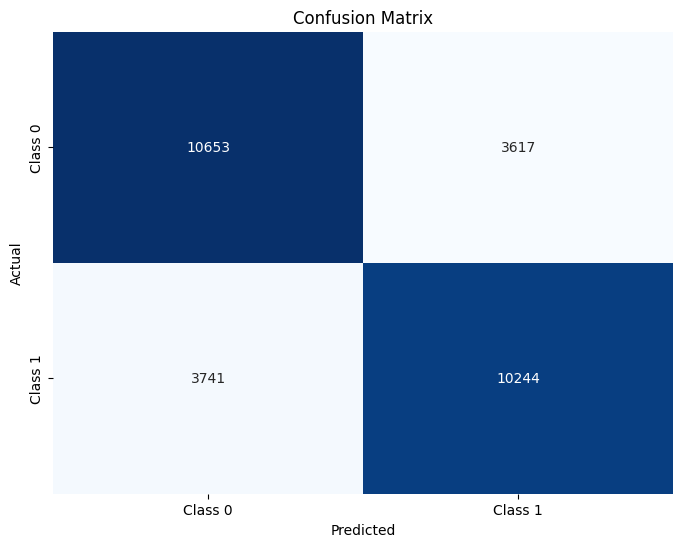

In [30]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

def plot_evaluation_results(predictions, targets, class_names):
    """
    Plots the confusion matrix and prints the classification report.
    
    Parameters:
    predictions (array-like): Array of model predictions.
    targets (array-like): Array of true labels.
    class_names (list): List of class names corresponding to the targets.
    """
    predictions_binary = (predictions > 0.5).astype(int)
    print("Classification Report:")
    print(classification_report(targets, predictions_binary, target_names=class_names))
    conf_matrix = confusion_matrix(targets, predictions_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Trainer.load_best_model()
val_predictions, val_targets = evaluate_model(Trainer.model, val)
class_names = ['Class 0', 'Class 1']

plot_evaluation_results(val_predictions, val_targets, class_names)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73      7409
     Class 1       0.71      0.68      0.69      6697

    accuracy                           0.71     14106
   macro avg       0.71      0.71      0.71     14106
weighted avg       0.71      0.71      0.71     14106



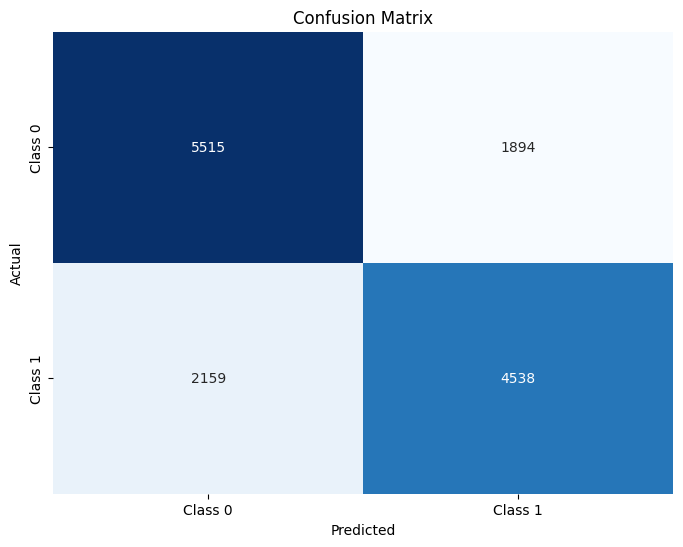

In [32]:
final_val_predictions, final_val_targets = evaluate_model(Trainer.model, final_val)
class_names = ['Class 0', 'Class 1']
plot_evaluation_results(final_val_predictions, final_val_targets, class_names)

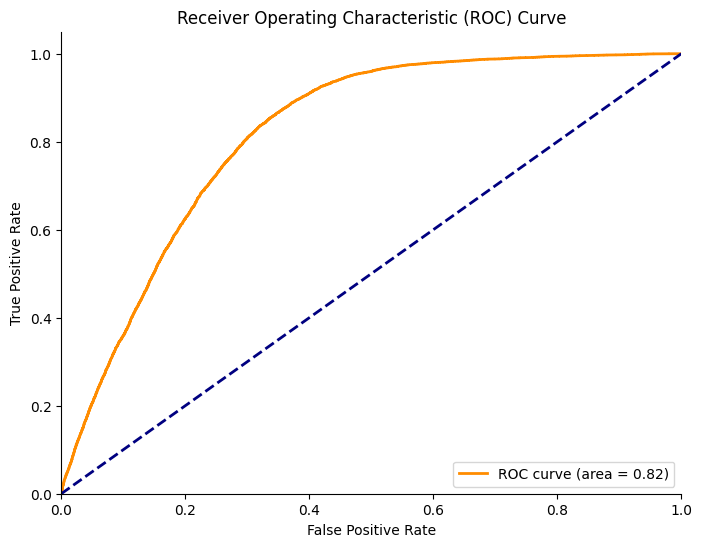

In [38]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(val_targets, val_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
sns.despine()
plt.show()

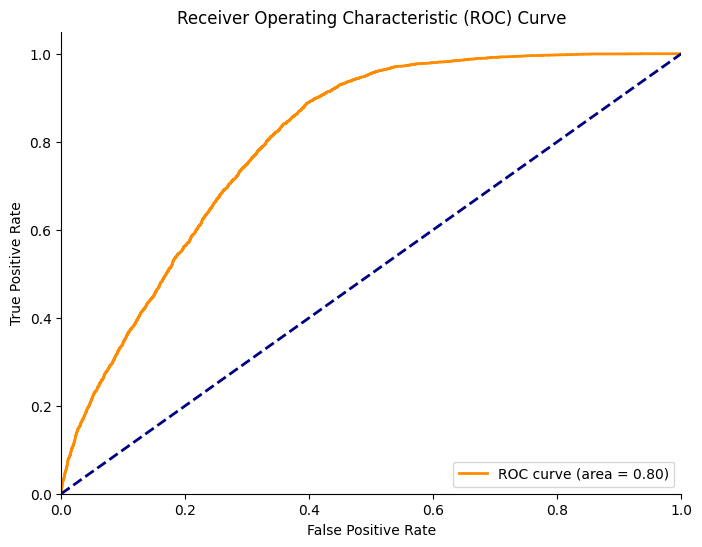

In [37]:
fpr, tpr, thresholds = roc_curve(final_val_targets, final_val_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
sns.despine()
plt.show()

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73      7409
     Class 1       0.71      0.68      0.69      6697

    accuracy                           0.71     14106
   macro avg       0.71      0.71      0.71     14106
weighted avg       0.71      0.71      0.71     14106



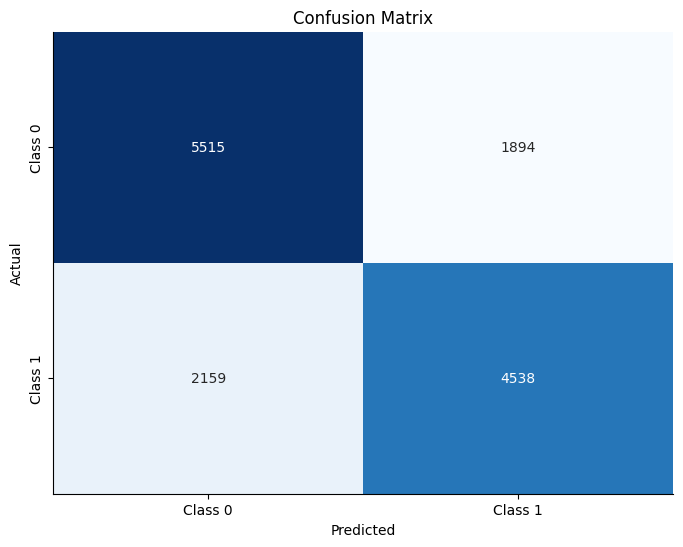

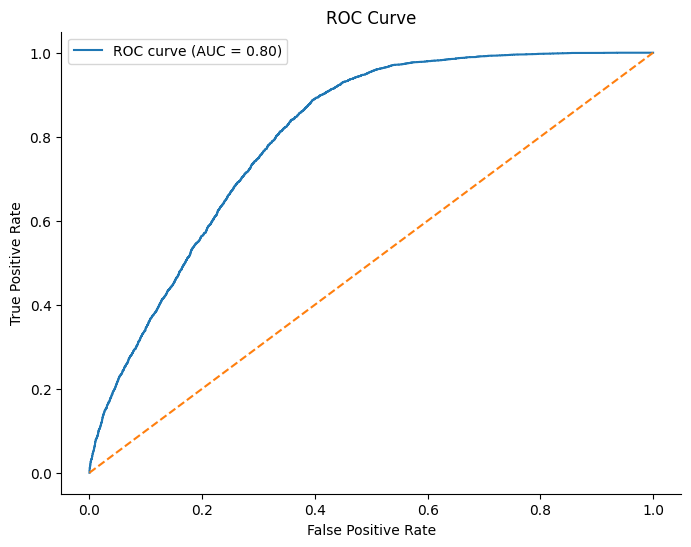

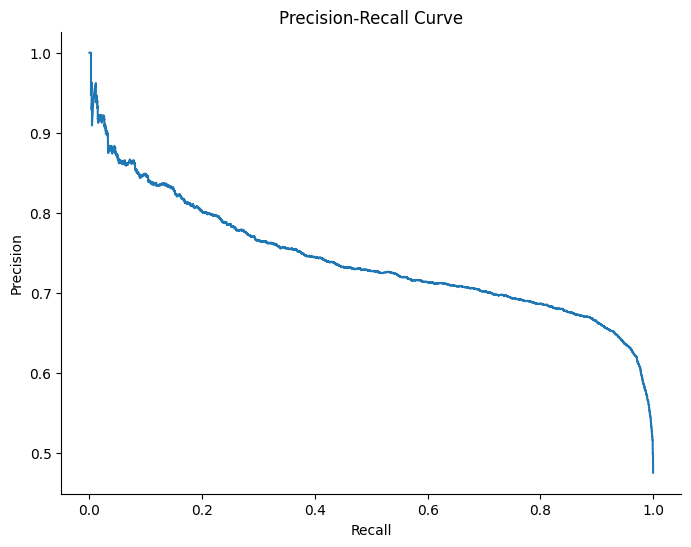

Log-Loss: 0.54
Cohen's Kappa: 0.42
Matthews Correlation Coefficient: 0.42
Balanced Accuracy: 0.71


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, log_loss, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plots a confusion matrix using seaborn heatmap with despine.
    
    Parameters:
    conf_matrix (array-like): Confusion matrix to be plotted.
    class_names (list): List of class names corresponding to the confusion matrix.
    """

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    sns.despine()  
    plt.show()

def extended_classification_report(predictions, targets, class_names):
    predictions_binary = (predictions > 0.5).astype(int)
    
    print("Classification Report:")
    print(classification_report(targets, predictions_binary, target_names=class_names))
    
    # Conf Matrix
    conf_matrix = confusion_matrix(targets, predictions_binary)
    plot_confusion_matrix(conf_matrix, class_names)
    
    # AUC-ROC
    auc = roc_auc_score(targets, predictions)
    fpr, tpr, _ = roc_curve(targets, predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    sns.despine() 
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(targets, predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    sns.despine()  
    plt.show()
    
    logloss = log_loss(targets, predictions)
    kappa = cohen_kappa_score(targets, predictions_binary)
    mcc = matthews_corrcoef(targets, predictions_binary)
    balanced_acc = balanced_accuracy_score(targets, predictions_binary)
    print(f'Log-Loss: {logloss:.2f}')
    print(f'Cohen\'s Kappa: {kappa:.2f}')
    print(f'Matthews Correlation Coefficient: {mcc:.2f}')
    print(f'Balanced Accuracy: {balanced_acc:.2f}')

extended_classification_report(final_val_predictions, final_val_targets, class_names)